In [51]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [52]:
from importlib import reload

import pickle
import time

import numpy as np
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

# Construct OPM

In [61]:
def gen_opm(sf,nk,N,seed=0):
    rng = np.random.default_rng(seed)
    
    x,y = np.meshgrid(np.arange(N)/N,np.arange(N)/N)

    z = np.zeros_like(x)
    
    for j in range(nk):
        fj = np.array([np.round(sf*np.cos(j*np.pi/nk)),
                       np.round(sf*np.sin(j*np.pi/nk))])
        print(fj,np.sqrt(fj[0]**2+fj[1]**2))
        sj = rng.choice([1,-1])
        phij = rng.random()*2*np.pi
        tmp = 2*np.pi*(x*fj[0]+y*fj[1])*sj + phij
        z = z + np.exp(1j * tmp)
        
    return z / nk

[6. 0.] 6.0
[5. 3.] 5.830951894845301
[3. 5.] 5.830951894845301
[0. 6.] 6.0
[-3.  5.] 5.830951894845301
[-5.  3.] 5.830951894845301


Text(0.5, 1.0, 'FFT of Normalized Z Field')

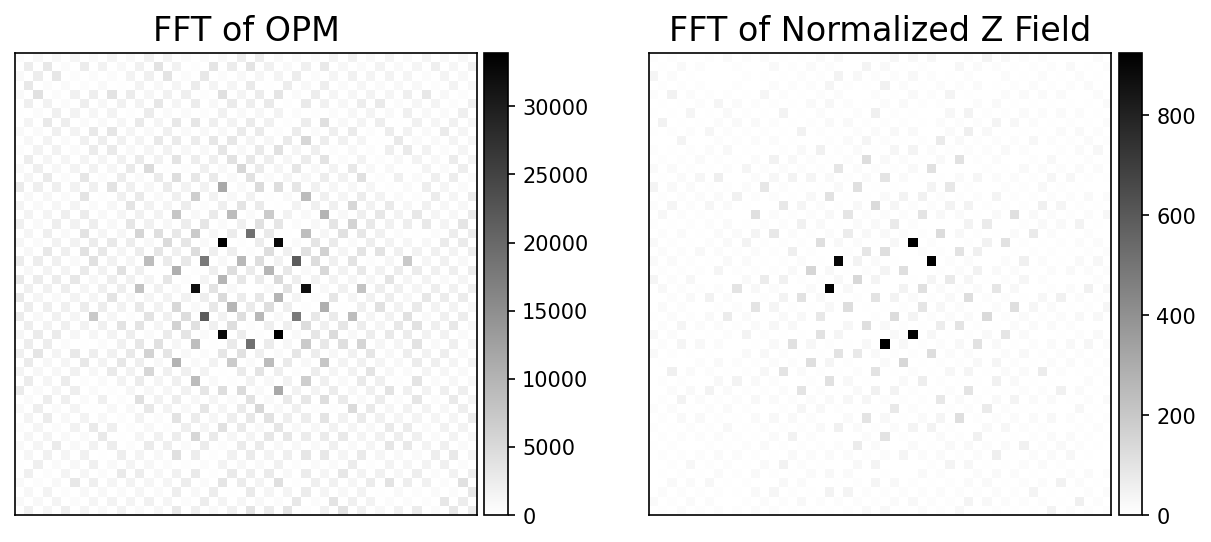

In [83]:
N4 = 50
z = gen_opm(6,6,N4)

ori = np.angle(z)*180/(2*np.pi)
sel = np.abs(z)
z_unit = z / sel
ori_fft = np.abs(np.fft.fftshift(np.fft.fft2(ori - np.nanmean(ori))))
z_unit_fft = np.abs(np.fft.fftshift(np.fft.fft2(z_unit - np.nanmean(z_unit))))
# ori_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# z_unit_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
ori_fps = np.zeros(N4//2)
z_unit_fps = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.5)
for idx in range(N4//2):
    ori_fps[idx] = np.mean(ori_fft[bin_idxs == idx])
    z_unit_fps[idx] = np.mean(z_unit_fft[bin_idxs == idx])
    
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

pf.imshowbar(fig,axs[0],ori_fft,cmap='binary')
pf.imshowbar(fig,axs[1],z_unit_fft,cmap='binary')

axs[0].set_title('FFT of OPM',fontsize=16)
axs[1].set_title('FFT of Normalized Z Field',fontsize=16)

In [71]:
N4 = 80
z = gen_opm(10,24,N4)

[10.  0.] 10.0
[10.  1.] 10.04987562112089
[10.  3.] 10.44030650891055
[9. 4.] 9.848857801796104
[9. 5.] 10.295630140987
[8. 6.] 10.0
[7. 7.] 9.899494936611665
[6. 8.] 10.0
[5. 9.] 10.295630140987
[4. 9.] 9.848857801796104
[ 3. 10.] 10.44030650891055
[ 1. 10.] 10.04987562112089
[ 0. 10.] 10.0
[-1. 10.] 10.04987562112089
[-3. 10.] 10.44030650891055
[-4.  9.] 9.848857801796104
[-5.  9.] 10.295630140987
[-6.  8.] 10.0
[-7.  7.] 9.899494936611665
[-8.  6.] 10.0
[-9.  5.] 10.295630140987
[-9.  4.] 9.848857801796104
[-10.   3.] 10.44030650891055
[-10.   1.] 10.04987562112089


Text(0.5, 1.0, 'Orientation Map')

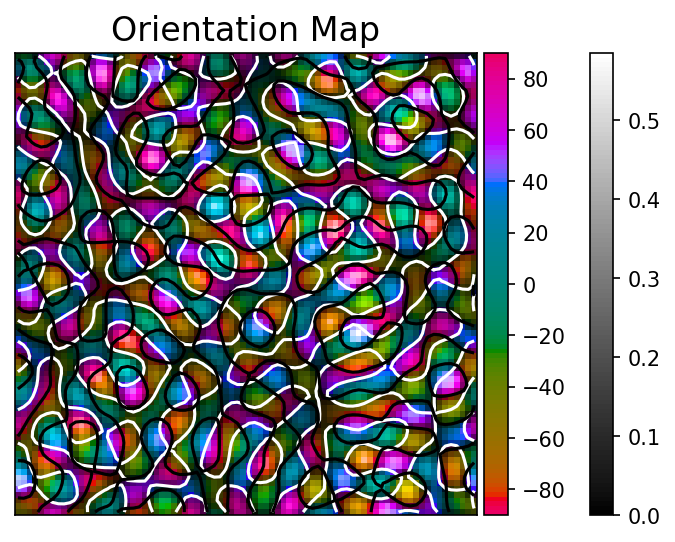

In [72]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=150)

pf.domcolbar(fig,axs,z,origin='lower',alim=[-90,90],rlim=[0,None])
rcont = axs.contour(np.real(z),levels=[0],colors="w")
icont = axs.contour(np.imag(z),levels=[0],colors="k")

axs.set_title('Orientation Map',fontsize=16)

Text(0.5, 1.0, 'Orientation Selectivity')

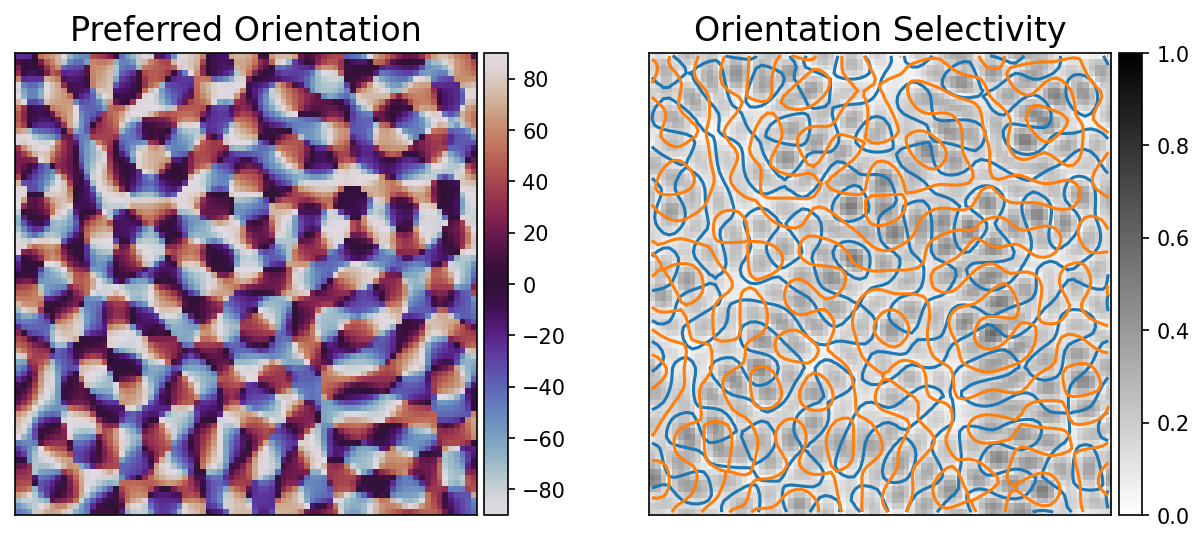

In [23]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

pf.imshowbar(fig,axs[0],np.angle(z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[1],np.abs(z),origin='lower',cmap='binary',vmin=0,vmax=1)
rcont = axs[1].contour(np.real(z),levels=[0],colors="C0")
icont = axs[1].contour(np.imag(z),levels=[0],colors="C1")
# pws = np.where(np.abs(z)<0.1)
# axs[1].scatter(pws[1],pws[0],c='r')

axs[0].set_title('Preferred Orientation',fontsize=16)
axs[1].set_title('Orientation Selectivity',fontsize=16)

# Calculate pinwheel density of OPM

## Calculate hypercolumn size

In [24]:
ori = np.angle(z)*180/(2*np.pi)
sel = np.abs(z)
z_unit = z / sel
ori_fft = np.abs(np.fft.fftshift(np.fft.fft2(ori - np.nanmean(ori))))
z_unit_fft = np.abs(np.fft.fftshift(np.fft.fft2(z_unit - np.nanmean(z_unit))))
# ori_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# z_unit_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
ori_fps = np.zeros(N4//2)
z_unit_fps = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.5)
for idx in range(N4//2):
    ori_fps[idx] = np.mean(ori_fft[bin_idxs == idx])
    z_unit_fps[idx] = np.mean(z_unit_fft[bin_idxs == idx])

Text(0.5, 1.0, 'FFT of Normalized Z Field')

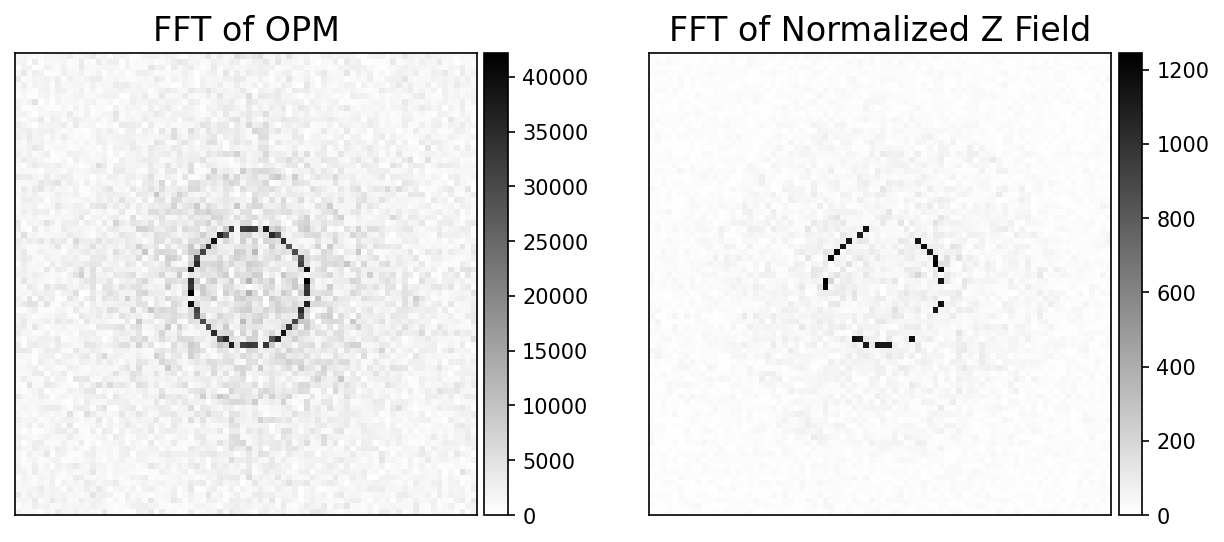

In [25]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

pf.imshowbar(fig,axs[0],ori_fft,cmap='binary')
pf.imshowbar(fig,axs[1],z_unit_fft,cmap='binary')

axs[0].set_title('FFT of OPM',fontsize=16)
axs[1].set_title('FFT of Normalized Z Field',fontsize=16)

(0.0, 21.081919005817976)

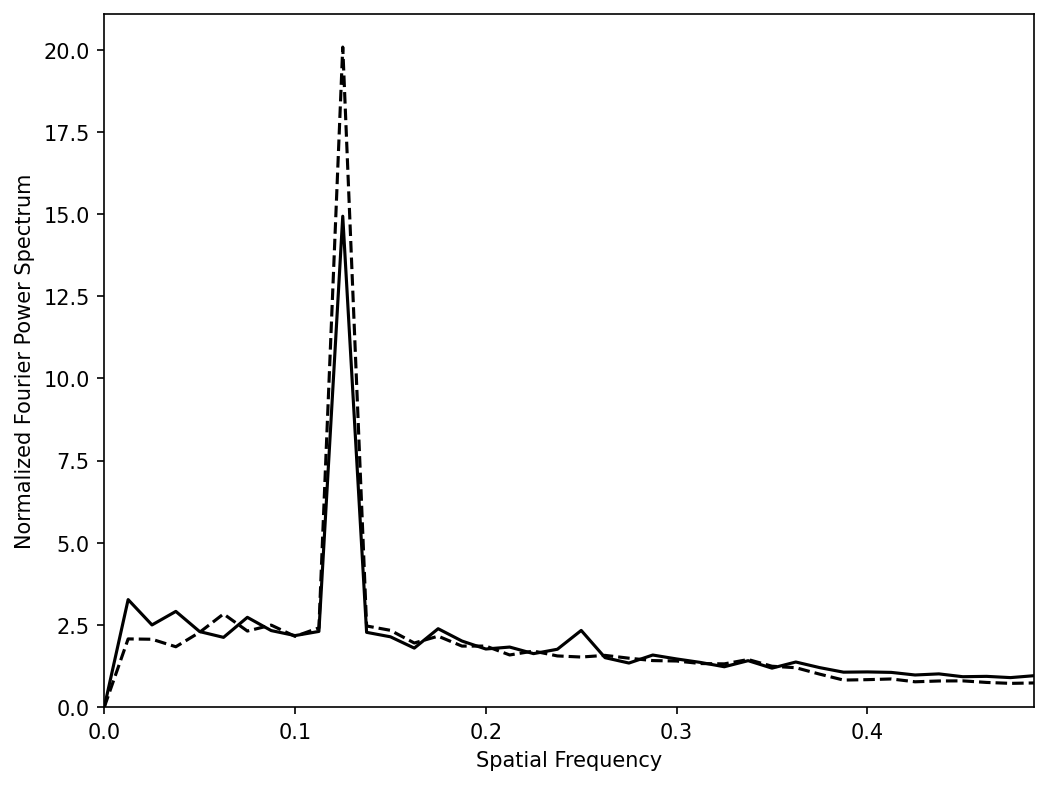

In [26]:
fig,axs = plt.subplots(1,1,figsize=(8,6),dpi=150)

# freqs = np.arange(int(np.ceil(N4//2*np.sqrt(2))))/N4
freqs = np.arange(N4//2)/N4

axs.plot(freqs,ori_fps/np.sum(ori_fps)*N4,'k')
axs.plot(freqs,z_unit_fps/np.sum(z_unit_fps)*N4,'k--')

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N4//2-1)/N4)
axs.set_ylim(0,None)

In [27]:
Lam = 1/freqs[np.argmax(z_unit_fps)]
print('Λ =',Lam)
print('Λ/L =',Lam/N4)

Λ = 8.0
Λ/L = 0.1


## Calculate total number of zero-crossings in OPM

In [28]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def cross(A,B):
    return A[0]*B[1] - A[1]*B[0]

def intersectpt(A,B,C,D):
    qmp = [C[0]-A[0],C[1]-A[1]]
    r = [B[0]-A[0],B[1]-A[1]]
    s = [D[0]-C[0],D[1]-C[1]]
    rxs = cross(r,s)
    
    t = cross(qmp,s)/rxs
#     u = cross(qmp,r)/rxs
    
    return [A[0]+t*r[0],A[1]+t*r[1]]

In [29]:
rsegpts = []
for pts in rcont.allsegs[0]:
    for i in range(len(pts)-1):
        rsegpts.append([pts[i],pts[i+1]])
rsegpts = np.array(rsegpts)

isegpts = []
for pts in icont.allsegs[0]:
    for i in range(len(pts)-1):
        isegpts.append([pts[i],pts[i+1]])
isegpts = np.array(isegpts)

In [30]:
pwcnt = 0
pwpts = []

for rsegpt in rsegpts:
    for isegpt in isegpts:
        if intersect(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]):
            pwcnt += 1
            pwpts.append(intersectpt(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]))
pwpts = np.array(pwpts)

In [31]:
print('N =',pwcnt)

N = 319


Text(0.5, 1.0, 'Orientation Map')

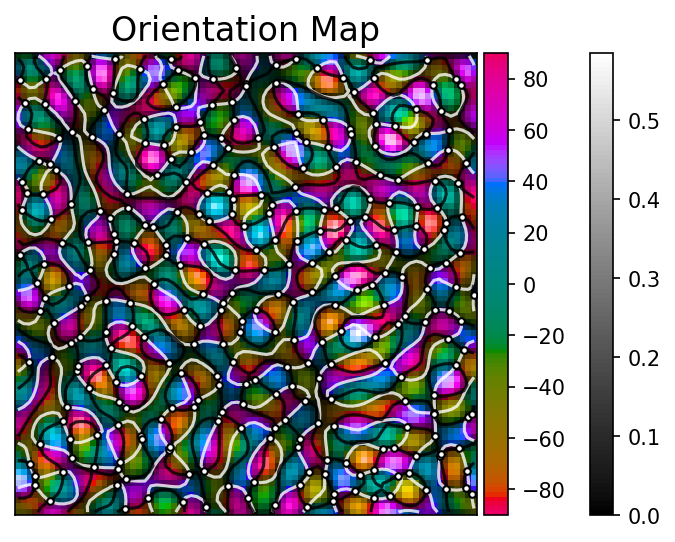

In [32]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=150)

pf.domcolbar(fig,axs,z,origin='lower',alim=[-90,90],rlim=[0,None],zorder=0)
rcont = axs.contour(np.real(z),levels=[0],colors="w",alpha=0.8,zorder=1)
icont = axs.contour(np.imag(z),levels=[0],colors="k",alpha=0.8,zorder=1)
axs.scatter(pwpts[:,0],pwpts[:,1],s=10,c='w',edgecolors='k',zorder=2)

axs.set_title('Orientation Map',fontsize=16)

Text(0.5, 1.0, 'Orientation Selectivity')

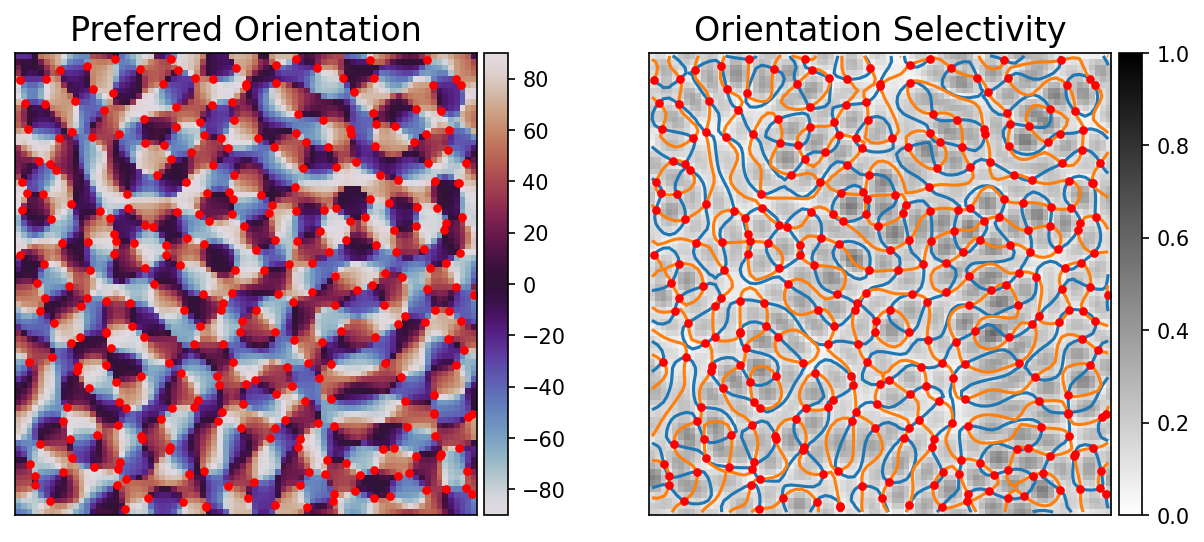

In [33]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

pf.imshowbar(fig,axs[0],np.angle(z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90,zorder=0)
axs[0].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)

pf.imshowbar(fig,axs[1],np.abs(z),origin='lower',cmap='binary',vmin=0,vmax=1,zorder=0)
rcont = axs[1].contour(np.real(z),levels=[0],colors="C0",zorder=1)
icont = axs[1].contour(np.imag(z),levels=[0],colors="C1",zorder=1)
axs[1].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)

axs[0].set_title('Preferred Orientation',fontsize=16)
axs[1].set_title('Orientation Selectivity',fontsize=16)

## Calculate pinwheel density

In [34]:
print('ρ = N (Λ/L)² =',pwcnt * (Lam/N4)**2)

ρ = N (Λ/L)² = 3.190000000000001


# Calculate orientation gradient

In [36]:
oris = np.angle(z)*180/(2*np.pi)

oris_dx = np.roll(oris,(1,0)) - oris
oris_dy = np.roll(oris,(0,1)) - oris

oris_dx[oris_dx >  90] -= 180
oris_dx[oris_dx < -90] += 180
oris_dy[oris_dy >  90] -= 180
oris_dy[oris_dy < -90] += 180

oris_ds = np.sqrt(oris_dx**2+oris_dy**2)

In [48]:
oris_dx

array([[37.13575207,  4.39042307,  7.82939368, ...,  7.9135957 ,
         7.13658697,  5.96584782],
       [14.44701406,  8.67084745,  6.33043929, ...,  6.51656127,
         6.57597588,  8.92971312],
       [24.71022263,  8.86994895,  0.08904843, ...,  5.10823727,
         5.47159242, 12.63126106],
       ...,
       [30.14627111, 22.15024275,  5.08287766, ...,  5.81975012,
         4.28823731,  8.38848303],
       [35.97003929, 15.01579434,  1.30380902, ...,  5.89244218,
         5.2874456 , 12.20216948],
       [63.67651755,  0.9473499 , -2.2464581 , ...,  4.38287457,
         6.73050037, 57.97726817]])

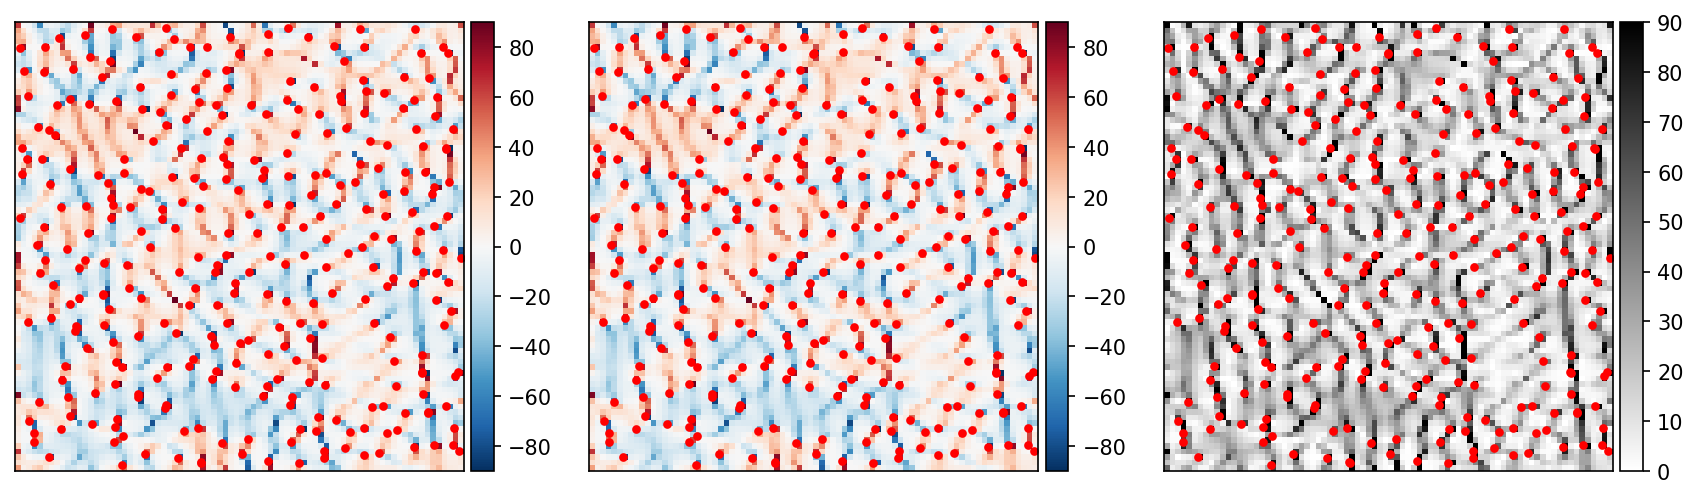

In [50]:
fig,axs = plt.subplots(1,3,figsize=(14,4),dpi=150)

pf.imshowbar(fig,axs[0],oris_dx,origin='lower',cmap='RdBu_r',vmin=-90,vmax=90,zorder=0)
axs[0].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)

pf.imshowbar(fig,axs[1],oris_dy,origin='lower',cmap='RdBu_r',vmin=-90,vmax=90,zorder=0)
axs[1].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)

pf.imshowbar(fig,axs[2],oris_ds,origin='lower',cmap='binary',vmin=0,vmax=90,zorder=0)
axs[2].scatter(pwpts[:,0],pwpts[:,1],s=10,c='r',zorder=2)

# axs[0].set_title('Orientation Gradient Magnitude',fontsize=16)
# axs[1].set_title('Orientation Selectivity',fontsize=16)

In [44]:
np.min(oris_ds)

0.006342974124577496